# Automated pH Adjustment of Liquid Formulations via Physics-Informed ML

### Aniket Chitre, Jayce Cheng, Sarfaraz Ahamed, Robert C.M. Querimit, Kedar Hippalgaonkar, Alexei A. Lapkin

Any questions, please contact ac2349@cam.ac.uk

**Last updated: 24.05.23**


# 0. Import Packages and Hardware Objects

In [1]:
#basic python packages required
import os
import sys
import time
import random
import pandas as pd
import numpy as np 
import sklearn
import matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 300
from datetime import datetime

# mathematics packages - to solve equations for titrants chemical system
import math
from sympy import Symbol, symbols, Eq, solve

# machine learning packages
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# hardware class object definitions to control the equipment via PySerial module
import serial 
sys.path.append("hardware/")

import C3000_SyringePumpsv2, Sentron_pHmeter, PlatformMovement, Stirrer_WashPump

from C3000_SyringePumpsv2 import C3000_pump # control of the Tricontinent C-Series syringe pumps 
from Sentron_pHmeter import SI600_pH # readings from the Sentron SI 600 pH electrode  
from PlatformMovement import Ender # control of the 3d-printer Ender platform for x, y, z robotic movements 
from Stirrer_WashPump import pH_stirrer_WashPump # control of the overhead stirrer and pump for wash station 

if not os.path.exists("titration_data"): # directory to save data from the titration runs 
    os.mkdir("titration_data")

# 1. Initialise Hardware and Protocol Functions

Lab hardware is controlled as serial objects connected via a USB-interface using the `PySerial` package.

Find the port number on Windows through Device Manager or on Mac through running this command (` ls /dev/tty.*`)  on the Terminal 

## 3d-Printer Platform

Useful information: 
* Max position dimensions: (220, 220, z) - this is a physical, mechanical limit
* Homes to (0, 0, 60) - *n.b.* absolute position units are in mm
* *N.b.* Ender platform can only be sent to up to 6 positions consecutively. 

In [2]:
platform = Ender('COM4') # initialise the Ender platform (robotic movement)
# default z_to_safe = True ensures it moves high enough to avoid crashing into any objects
# z-safe programmed to +90 for configuration of pH bot

0, 0, 90


In [ ]:
# print(platform.current_x, platform.current_y, platform.current_z)
# platform.to_position((0,0,35)) # co-ordinates must be specified as a tuple
# platform.home()

### Labware Coordinate Definitions

In [3]:
jar_pos = {
    'A1_1':(52, 60, 36), 'B1_1':(95.6, 60, 36), 'A2_1':(52, 103, 36), 'B2_1':(95.6, 103, 36), 'A3_1':(52, 147, 36), 'B3_1':(95.6, 148, 36),
    'A1_2':(161, 60, 36),'B1_2':(205, 60, 36),'A2_2':(160, 103, 36),'B2_2':(205, 103, 36), 'A3_2':(160, 147, 36),'B3_2':(205, 148, 36)
        }

jars = ['A3_1','B3_1','A3_2','B3_2',
        'A2_1','B2_1','A2_2','B2_2',
        'A1_1','B1_1','A1_2','B1_2'] 

# co-ordinates of wash staton
wash_stn     = (127, 218, 34) # submerge the pH probe & stirrer in the wash station.
wash_stn_dry = (127, 218, 80) # lift the pH probe & stirrer head out of the wash station to a drying position.

In [4]:
def touch_tip(jar, x_off=6, z_off=3):
    
    '''
    Brings end of the dosing needles to touch tip against the side of the sample jar.
    Dislodges any droplets suspended via capillary forces at the end of the acid/base needles.
    (Mimicks the touch_tip function of the Opentrons robot.)
    
    Parameters:
    jar = ['A1_1', ... , 'B3_2'] position - will call the relevant positions from the jar_pos dict.
    '''

    # offsets required for touch_tip 
    x_axis_off = x_off
    z_axis_off = z_off
    
    a_right = jar_pos[jar][0] + x_axis_off 
    a_left  = jar_pos[jar][0] - x_axis_off
    b       = jar_pos[jar][1]
    c       = jar_pos[jar][2] + z_axis_off
    
    # z_to_safe = False, as only want quick x, y motion to remove residual droplet at needle tip 
    
    platform.to_position(coord=(a_right, b, c), z_to_safe=False) # touch right 
    
    platform.to_position(coord=(a_left, b, c), z_to_safe=False)  # touch left 

    platform.to_position(coord=jar_pos[jar], z_to_safe=False)    # return centre 

## C-Series Syringe Pumps

In [5]:
# Connect to syringe pumps via serial connection
pump_1 = C3000_pump('COM7', '1') # base pump
pump_2 = C3000_pump('COM7', '2') # acid pump

In [6]:
pump_1.connect()

True

In [7]:
pump_2.connect()

True

In [21]:
pump_1.initialise() # syringe moves to zero-position: caution! results in emptying of syringe.

True

In [22]:
pump_2.initialise()

True

In [ ]:
pump_1.prime('3') # default 3 cycles required to sufficiently prime the pump

In [ ]:
pump_2.prime('3')

### Dose function

In [23]:
def dose(chem, vol, jar, init_vel=50, top_vel=200):
    
    '''
    Dose from the Tri-Continent C-3000 syringe pumps 
    
    paramters:
    chem     = 'acid' or 'base'
    vol      = volume/uL
    jar      = position being dispensed to
    init_vel = initial velocity of the syringe plunger (increments/sec)
    top_vel  = top velocity of the syringe plunger - don't change default arguments unless necessary
    '''

    if chem == 'base':
        pump_1.dose(vol, init_vel, top_vel)
    elif chem == 'acid':
        pump_2.dose(vol, init_vel, top_vel) 
        
    touch_tip(jar) # touch tip to side of jars to remove residual drops at tip of dosing needles

#### Dose from pump 1 (base)

In [ ]:
pump_1.dose(70, 50, 200)

#### Dose from pump 2 (acid)

In [ ]:
pump_2.dose(250, 50, 200)

## Sentron pH Meter

In [9]:
pH_meter = SI600_pH('COM10') # connect to pH meter via serial connection

In [ ]:
# initial_pH = pH_meter.reading()[5:10]
# float(initial_pH)

#### Move Between Jar Positions (Buffer Solutions) for pH Probe Calibration 

In [19]:
platform.to_position(jar_pos['A1_1'])

In [20]:
platform.home()

0, 0, 90


## Stirrer and Pump for Wash Station

In [10]:
stirrer_washpump = pH_stirrer_WashPump('COM3') # propeller and 2 pumps on ardunio connected via USB - serial port

In [14]:
stirrer_washpump.stir_pump(0,0,0, print_statement=True)

Stirring at 0 speed and wash station inlet and outlet pumps at 0 & 0 speeds, respectively.


### `stirrer_washpump.stir_pump(arg1, arg2, arg3)` - the 3 arguments correspond to: 

1. The speed of the propeller - keep at top speed = 255 to maximise stirring efficiency, especially important for viscous samples.
2. The speed of the inlet pump to the wash tank - keep at 180.
3. The speed of the outlet pump to the wash tank - also keep at 180. 

*N.b.* The pumps are quite powerful and don't need to be run at their full capacity (255).

In [24]:
def wash():
    platform.to_position(wash_stn)  # move the probe & stirrer to the wash station
    time.sleep(20)  # wait 20 seconds to allow the probe & stirrer to get to position
    stirrer_washpump.stir_pump(255, 180, 0) # start the IPA wash & jets - spin the propeller, results in self-cleaning
    time.sleep(7.5) # 7.5 seconds is sufficient for the wash tank to fill to the level of the jets
    stirrer_washpump.stir_pump(0, 180, 180) # start the wash tank outlet pump to prevent overflowing
    time.sleep(7.5) # total 15 seconds of washing in IPA - ~ 300 mL IPA so 12 samples ~ 1 5 L IPA bottle
    stirrer_washpump.stir_pump(0, 0, 180) # run just the outlet pump to empty the tank, otherwise could overfill next time
    time.sleep(10)
    stirrer_washpump.stir_pump(255, 0, 0) # keep the stirrer spinning
    time.sleep(10)
    platform.to_position(wash_stn_dry) # let the probe & stirrer sit outside the wash station to dry for 30 seconds
    time.sleep(30)
    stirrer_washpump.stir_pump(0, 0, 0)
    print("Washing complete")

In [35]:
wash()

Washing complete


### Channels to the Wash Station - to minimise cross-contamination via drippage

In [25]:
def channel_stirrer(jar):
    '''
    After mixing the more viscous samples, there is viscous residue left on the propeller and probe.
    This would drip into the neighbouring sample jars, thereby contaminating them, if the most direct path to the wash station was used.
    Instead this function ensures the robot moves via empty channels (created between the jar holders) to the wash station.
    '''
    
    if jar == 'B1_1' or jar == 'B2_1' or  jar == 'B3_1':
        
        x_axis_off = 28
        
        a = jar_pos[jar][0] + x_axis_off
        b = jar_pos[jar][1]
        c = jar_pos[jar][2]
        
        platform.to_position(coord=(a, b, 90), z_to_safe = False)
        platform.to_position(coord=(a,218,90), z_to_safe = False)
        platform.to_position(coord=(127,218,90), z_to_safe = False)
        
    if jar == 'A1_1' or jar == 'A2_1' or jar == 'A3_1':

        x_axis_off = 32
        
        a = jar_pos[jar][0] - x_axis_off
        b = jar_pos[jar][1]
        c = jar_pos[jar][2]
        
        platform.to_position(coord=(a, b, 90), z_to_safe = False)
        platform.to_position(coord=(a,218,90), z_to_safe = False)
        platform.to_position(coord=(127,218,90), z_to_safe = False)

# 2. Chemistry-Informed ML-driven pH Adustment Algorithm

## 2.1 The Chemistry of The Titrants

The developed method is completely general to work with any acid/base strong-strong, weak/strong, or strong/weak titrant pairs. Only a classification of whether a particular acid or base is strong or weak and its respective acid/base hydrolysis constant(s) information is required. This has been included in Python dictionaries for the following: `"Hydrochloric acid"`, `"Nitric acid"`, `"Sulfuric acid"`,`"Acetic acid"`,`"Carbonic acid"`, `"Citric acid"`, `"Sodium hydroxide"`,`"Potassium hydroxide"`,`"Calcium hydroxide"`, `"Ammonia solution"`. 

More substances can easily be added. With this in mind, this project was originally concieved with the need to **titrate viscous liquid formulated products to an industrially specified target pH using citric acid/sodium hydroxide**. 

In [26]:
acid_strength = {
    "Hydrochloric acid": "Strong",
    "Nitric acid": "Strong",
    "Sulfuric acid": "Strong",
    "Acetic acid": "Weak",
    "Carbonic acid": "Weak",
    "Citric acid": "Weak"
}

base_strength = {
    "Sodium hydroxide": "Strong",
    "Potassium hydroxide": "Strong",
    "Calcium hydroxide": "Strong",
    "Ammonia solution": "Weak"
}
# the maximum number of protons which can be released from 1 acid molecule - max normality of the acid
acid_n = {
    "Hydrochloric acid": 1,
    "Nitric acid": 1,
    "Sulfuric acid": 2,
    "Acetic acid": 1,
    "Carbonic acid": 2,
    "Citric acid": 3
}

# the maximum number of hydroxide ions which can be released from 1 base molecule - max normality of the base
base_n = {
    "Sodium hydroxide": 1,
    "Potassium hydroxide": 1,
    "Calcium hydroxide": 2,
    "Ammonia solution": 1
}

# acid hydrolysis equilibria constants
acid_Ka = {
    "Acetic acid": [1.8e-5],
    "Carbonic acid": [4.4e-7, 4.7e-11],
    "Citric acid": [7.4e-4, 1.7e-5, 4.0e-7]
}

#  base hydrolysis equilibria constants
base_Kb = {
    "Ammonia solution": [1.8e-5]
}

Kw = 1e-14  # auto-ionisation of water constant @ 25 deg C

In [27]:
def equivalence_point(titrant_A, titrant_B, A_conc, B_conc):
    """
    Takes an acid-base pairs, and their concentrations, and returns the pH at the equivalence point if you titrated the two against each other.
    """

    if acid_strength[titrant_A] == "Strong" and base_strength[titrant_B] == "Strong":
        return 7.0  # strong-strong pair has its equivalence point at pH 7

    elif acid_strength[titrant_A] == "Weak" and base_strength[titrant_B] == "Strong":

        conj_base_0 = A_conc * acid_n[titrant_A] / (1 + A_conc * acid_n[titrant_A] / B_conc * base_n[titrant_B])  # initial concentration of the conjugate base of the weak acid
        Kb = Kw / acid_Ka[titrant_A][-1]     # from Ka.Kb = Kw - take the lowest Ka value (for the final dissociation), hence [-1]

        b = Symbol('b')  # b = [OH-]
        eqn = b ** 2 + Kb * b - Kb * conj_base_0

        sol = solve(eqn, b)  # solve the quadratic equation for [OH-]

        pos_root = [r for r in sol if r > 0][0]     # take only the positive root

        return 14 + math.log10(pos_root)    # pH = 14 - pOH

    elif acid_strength[titrant_A] == "Strong" and base_strength[titrant_B] == "Weak":

        conj_acid_0 = B_conc * base_n[titrant_B] / (1 + B_conc * base_n[titrant_B] / A_conc * acid_n[titrant_A])  # initial concentration of the conjugate acid of the weak base

        Ka = Kw / base_Kb[titrant_B][-1]

        a = Symbol('a')  # a = [H3O+]
        eqn = a ** 2 + Ka * a - Ka * conj_acid_0

        sol = solve(eqn, a)  # solve the quadratic equation for [H+]

        pos_root = [r for r in sol if r > 0][0]     # take only the positive root

        return -math.log10(pos_root)    # pH = -log10([H3O+])

    else:   # we are not considering weak-weak acid base pairs as these are not of practical interest
        print("Please select a non weak acid/weak base pair.")   # raise an error for the user to select a different acid-base pair.

In [28]:
def w(pH, EQ_pH, dampen):
    """
    A dampening function which passes through (pH = 0, w = 0), (pH = 14, w = 0) and with a maxima at the equivalence point pH.
    Input: pH value [0-14], equivalence point, dampening factor [0-1]
    For strong-strong acid pairs a simple quadratic function is used.
    However, for weak strong acid-pairs a rational function approximation of the form y = ax + b + c/(d+x) is used.
    The `sympy` Python package is used to solve the resulting system of equations.
    """

    if EQ_pH == 7.0:

        return dampen * (-pH ** 2 / 49 + 2 * pH / 7)

    else:

        # Define the variables
        a, b, c, d = symbols('a b c d')

        # Define the equations
        eq1 = Eq(a - c / (EQ_pH + d) ** 2, 0)
        eq2 = Eq(EQ_pH * a + b + c / (EQ_pH + d), 1)
        eq3 = Eq(b + c / d, 0)
        eq4 = Eq(14 * a + b + c / (14 + d), 0)

        # Solve the system of equations
        sol = solve((eq1, eq2, eq3, eq4), (a, b, c, d))

        a, b, c, d = sol[0][0], sol[0][1], sol[0][2], sol[0][3]

        return dampen * (a * pH + b + c / (d + pH))

In [29]:
def species_effective_conc(titrant_A, A_conc, titrant_B, B_conc, pH):
    """
    Computes the effective concentration of protons or hydroxide ions released into solution.
    This is chemistry and pH-dependent.
    """

    x = np.power(10, -pH)   # x = [H3O+]

    pOH = 14 - pH
    y = np.power(10, -pOH)  # y = [OH-]

    if acid_strength[titrant_A] == "Weak" and len(acid_Ka[titrant_A]) == 1 and base_strength[titrant_B] == "Strong":

        Ka = acid_Ka[titrant_A][0]
        frac_A = Ka / (Ka + x)
        a_eff = frac_A * A_conc
        b_eff = B_conc * base_n[titrant_B]

    elif acid_strength[titrant_A] == "Weak" and len(acid_Ka[titrant_A]) == 2 and base_strength[titrant_B] == "Strong":

        Ka1 = acid_Ka[titrant_A][0]
        Ka2 = acid_Ka[titrant_A][1]

        frac_A = (Ka1 * Ka2) / (x ** 2 + Ka1 * x + Ka1 * Ka2)
        frac_HA = (Ka1 * x) / (x ** 2 + Ka1 * x + Ka1 * Ka2)

        a_eff = (2 * frac_A + 1 * frac_HA) * A_conc

        b_eff = B_conc * base_n[titrant_B]

    elif acid_strength[titrant_A] == "Weak" and len(acid_Ka[titrant_A]) == 3 and base_strength[titrant_B] == "Strong":

        Ka1 = acid_Ka[titrant_A][0]
        Ka2 = acid_Ka[titrant_A][1]
        Ka3 = acid_Ka[titrant_A][2]

        frac_A = (Ka1 * Ka2 * Ka3) / (x ** 3 + Ka1 * x ** 2 + Ka1 * Ka2 * x + Ka1 * Ka2 * Ka3)
        frac_HA = (Ka1 * Ka2 * x) / (x ** 3 + Ka1 * x ** 2 + Ka1 * Ka2 * x + Ka1 * Ka2 * Ka3)
        frac_H2A = (Ka1 * x ** 2) / (x ** 3 + Ka1 * x ** 2 + Ka1 * Ka2 * x + Ka1 * Ka2 * Ka3)

        a_eff = (3 * frac_A + 2 * frac_HA + 1 * frac_H2A) * A_conc

        b_eff = B_conc * base_n[titrant_B]

    elif acid_strength[titrant_A] == "Strong" and base_strength[titrant_B] == "Weak" and len(base_Kb[titrant_B]) == 1:

        a_eff = A_conc * acid_n[titrant_A]

        Kb = base_Kb[titrant_B][0]
        frac_B = Kb / (Kb + y)
        b_eff = frac_B * B_conc

    else:

        a_eff = A_conc * acid_n[titrant_A]
        b_eff = B_conc * base_n[titrant_B]

    return a_eff, b_eff

In [30]:
def hydroxonium_hydroxide(V, titrant_A, A_conc, titrant_B, B_conc, pH):
    """
    Function converts from volume to moles.
    """

    C_acid_eff, C_base_eff = species_effective_conc(titrant_A, A_conc, titrant_B, B_conc, pH)

    if V >= 0:
        n = C_base_eff * V
    else:
        n = C_acid_eff * V
    return n


def vol_acid_base(n, titrant_A, A_conc, titrant_B, B_conc, pH):
    """
    Function converts from moles to volume, which is dependent on pH for the weak acid.
    """

    C_acid_eff, C_base_eff = species_effective_conc(titrant_A, A_conc, titrant_B, B_conc, pH)

    if n >= 0:
        V = n / C_base_eff
    else:
        V = n / C_acid_eff

    return V

## 2.2 pH Adjustment Algorithm: Automation x ML

<div>
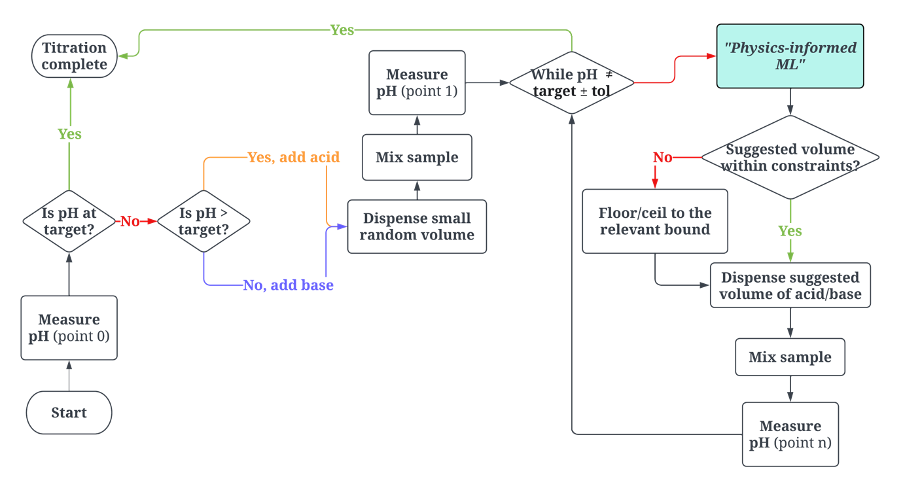
</div>

In [31]:
def pH_tit_vol(df, pH_target):

    '''
    Reads a DataFrame containing the amount of acid/base added and resulting pH measurements.
    Outputs a data-driven suggestion for the number of moles of titrant required to reach the target pH.
    '''

    # inputs from the df need to be re-formatted into numpy arrays for the ML packages
    x = [df['Net moles of protons(-)/hydroxide(+) (\u03BCmol)']]
    y = [df['pH of Sample']]
    X = np.reshape(x, (-1,1)) 
    Y = np.reshape(y, (-1,1)) 
    
    # Method involves developing a surrogate model to the titration curve
    # The surrogate model is a Gaussian Process with a mean function modelled by a linear regression model.
    # This enables us to reflect that titration curves are always monotonically increasing functions. 
    
    lin_reg = LinearRegression(positive=True) # Forces the slope of the titration curve to be positive 
    
    lin_reg.fit(X,Y)
    
    m = lin_reg.coef_
    b = lin_reg.intercept_

    # Model the pH on a domain as wide as the intersection points of the linear model and pH 1 & 14
    pH_LB = 1
    pH_UB = 14 
    
    LB = (pH_LB - b)/m  # x @ pH 1
    UB = (pH_UB - b)/m  # x @ pH 14 
    
    x_grid = np.linspace(LB, UB, num=100).reshape(-1,1)
    
    plt.close('all')
    
    if len(df.index) == 2:
        
        # First call of the ML algorithm, select the amount of acid/base using only the linear model
        
        y_lin_pred = lin_reg.predict(x_grid)
        
        f, ax = plt.subplots(1, 1, figsize=(6, 4))
        
        ax.scatter(x, y, c='k', marker='*', label='Observed Data');
        ax.plot(x_grid, y_lin_pred, 'g-', label='Initial Prediction');
        ax.set_xlabel('Net moles of protons(-)/hydroxide(+) (\u03BCmol)');
        ax.set_ylabel('pH');
        ax.set_ylim([pH_LB, pH_UB]);
        ax.legend();
        plt.show()
        
        # "acquisition function"
        ix = np.argmin(abs(y_lin_pred - pH_target))
        new_mol = x_grid[ix]
        
    else:
        
        y_lin_pred = lin_reg.predict(X)
        err        = Y - y_lin_pred
        
        # Selection of appropriate kernel bounds very important
        AC = RBF(length_scale=1, length_scale_bounds=(.001, 5000))

        gp_reg = GaussianProcessRegressor(n_restarts_optimizer=250, random_state=42, kernel=AC)

        # Build a GP model over the error of the linear model
        gp_reg.fit(X, err)
        
        err_pred, sigma = gp_reg.predict(x_grid, return_std=True)
        
        err_pred = err_pred.reshape(-1,1)
        sigma = sigma.reshape(-1,1)
        
        surrogate = lin_reg.predict(x_grid) + err_pred
        
        f, ax = plt.subplots(1, 1, figsize=(6, 4))

        ax.scatter(x, y, c='k', marker='*', label='Observed Data');
        ax.plot(x_grid, surrogate, 'g-', label='Mean');
        ax.set_xlabel('Net moles of protons(-)/hydroxide(+) (\u03BCmol)');
        ax.set_ylabel('pH');
        UB_95CI = surrogate + 1.96*sigma # UB 95% confidence interval
        LB_95CI = surrogate - 1.96*sigma # LB 95% confidence interval 
        ax.fill_between(x_grid.reshape(-1), UB_95CI.reshape(-1), LB_95CI.reshape(-1), color='tab:green', alpha=0.50, label='95% Confidence');
        ax.set_ylim([pH_LB, pH_UB]);
        ax.legend();
        plt.show()
        
        # "acquisition function"
        ix = np.argmin(abs(surrogate - pH_target)) 
        new_mol = int(x_grid[ix])
    
    print(f"Predicted moles of H+/OH- ions to reach target (pH = {pH_target}): {int(new_mol)} umol.")
    
    return new_mol # new mol is the TOTAL amount of moles predicted to reach the target pH

In [32]:
def pH_adj(jar, pH_dev, dpHdt_dev, titrant_A="Citric acid", titrant_B="Sodium hydroxide", A_conc=0.5, B_conc=0.5,
           V_sample=10, pH_target=5.8, pH_tol=0.20, delta_initial=0.1, max_stir_t=300,
           zeta=0.7, mu=0.7, init_LB_perc=0.5, init_UB_perc=1.0, max_acid = -800, max_base=800):
    
    '''
    pH Adjustment Algorithm - titrates a single sample to within a target_pH +/- pH_tol. Key features include:
    - Control of the robotic platform. The hardware is controlled through this function. 
    - Calls the above pre-defined functions to carry out the titration based on knowledge of the titrants' physical chemistry.
    - Multi-stage algorithm: changes tact based on the iteration of pH adjustment and also whether the target has been overshot.
    - The suggestion and addition of acid/base is constrained within user-specified bounds. 
    - The mixing time after acid or base addition is dynamically controlled to optimise the time this protocol takes.
    
    Note several parameters are given as default arguments as either:
    i) The algorithm is used for a fixed industrially specified problem statment - but the method is general and other arguments can be selected.
    ii) The parameters have been optimised via trial-and-error to work well with the ACJC titration bot. 

    Inputs:
    jar             = Sample to be titrated
    pH_dev          = Acceptable deviation of the pH value for the pH to be considered at steady state after acid or base addition.
    dpHdt_dev       = Acceptable deviation of derivative of the pH w.r.t time " " at steady state.
    titrant_A       = Choice of acid - spelling must match the dictionaries storing the titrant's chemical information.
    titrant_B       = Choice of base " ".
    A_conc/B_conc   = Concentration of acid/base (M)
    V_sample        = Volume of sample to be titrated (mL)
    pH_target/tol   = (default value = 5.80) - industry partner specified target with a +/- 0.20 pH_tol
    delta_initial   = Minimum deviation of the pH post acid or base deviation for the pH to be considered to have changed. Used in dynamic control of the mixing time. 
    max_stir_t      = Maximum stirring time (s). If the pH has not stabilised within this time, stop stirring anyways. 
    zeta            = Weighting factor on 1st step - dampens the suggested titrant addition to prevent overshooting. [0-1]
    mu              = Dampening factor in buffering region [0-1]
    init_LB/UB_perc = Limits for the random small addition of titrant in the beginning to generate initial data (%)
    max_acid/base   = Maximum volume of acid/base to be added (uL) 
    '''
        
    # Operational constants
    
    min_disp = 25 # Volume of 1 drop ~ 15-25 uL so liquid handling is not as accurate below this volume, hence set min.
    
    stirrer_off  = 0
    stirrer_on   = 255
    in_pump_off  = 0
    in_pump_on   = 180
    out_pump_off = 0
    out_pump_on  = 180
    
    def pH_stable_check_bool(pH_list, dpHdt_list, pH_dev, dpHdt_dev):
        '''
        Checks whether the difference between consecutive pH points is below an acceptable deviation limit.
        And checks that the change in pH is also above a limit, i.e., threshold. 
        When the two criterion are met simulataneously the reading is considered stable.

        Inputs:
        pH_list & dpHdt_list: pH and its derivative w.r.t time.
        pH_dev: maximum acceptable deviance for the pH to be at steady state.
        dpHdt_dev: maximum acceptive deviance of the derivative of pH w.r.t. time.
        '''
        stable_check = [] # initiate an empty list
        for i in range(1,len(pH_list)-1): # start at index 1 as we'll look at the difference [i] - [i-1]
            if (abs(pH_list[i] - pH_list[i-1])<pH_dev) & (abs(dpHdt_list[i]) < dpHdt_dev): 
                stable_check.append(True) # pH reading has stabilised.
            else:
                stable_check.append(False) # not reached steady state yet.
        return stable_check # boolean list
    
    def detect_consecutive_true_index(boolean_list, n):
        '''
        Inputs:
        boolean_list: output from pH_stable_check_bool
        n: number of intervals over which we check whether the pH is stable.
        '''
        count = 0 # initialise counter
        for i, value in enumerate(boolean_list): # iterates through the boolean_list
            if value: 
                count += 1 # each time True is encountered the counter is incremeted
                if count == n: 
                    return i # if we reach n, return the index as i - it'll then exit the loop & so only return the first occurence of this.
            else:
                count = 0

        return -1  # Return -1 if a sufficient number of consecutive True values are NOT found
    
    def mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial, interval_t=3, min_stir_intervals=3):
        '''
        Dynamically control the stirring after acid/base addition until the pH stabilises or a max time is reached.
        
        Inputs:
        pH_dev, dpHdt_dev  = Thresholds to check that the pH has reached steady state (also see definitions above).
        max_stir_t         = Maximum stirring time (s).
        pH_premix          = pH reading before mixing. 
        delta_initial      = (See above).
        interval_t         = Time between pH measurements will be ~ interval_t + 1 + 1 (s). N.b. +2 seconds from communication with pH meter.
        min_stir_intervals = Minimum number of time intervals the pH needs to be stable over to be considered stabilised - here 3*(3+1+1) = 15 seconds.
        '''
        stirrer_washpump.stir_pump(stirrer_on, in_pump_off, out_pump_off) # turn the stirrer on
        
        time_elapsed = 0 
        start_t      = time.time() # start stopwatch 
        
        # initialise data structures to log the pH data
        pH_log    = []
        time_log  = []
        dpHdt_log = []
        
        i = 0 # initialise counter 
        
        n = min_stir_intervals  # set criterion that the pH remains stable over min_stir_intervals. 
        
        stable = False # initialise that the pH reading is unstable
        
        while stable==False: 
        # Keep stirring and recording the pH until it stabilises as long as we have not passed a set max stir time.
            
            if len(pH_log) < 1: # only record the pH, can't take the derivative yet.
                
                pH_log.append(float(pH_meter.reading()[5:10]))
                time_log.append((interval_t+2)*i) # time between intervals = interval_t + 2 due to communication with the pH meter.
                i += 1 # increment the counter
                time.sleep(interval_t) 
                
            elif len(pH_log) <= min_stir_intervals: # stirring will take place for at least min_stir_intervals*(interval_t + 2) seconds.
                
                pH_log.append(float(pH_meter.reading()[5:10]))
                time_log.append((interval_t+2)*i)
                dpHdt_log.append((pH_log[i] - pH_log[i-1])/(time_log[i] - time_log[i-1])) # numercial differentiation dy/dx
                i += 1
                time.sleep(interval_t)
                
            else:
                
                pH_log.append(float(pH_meter.reading()[5:10]))
                time_log.append((interval_t+2)*i)
                dpHdt_log.append((pH_log[i] - pH_log[i-1])/(time_log[i] - time_log[i-1]))
                
                pH_stable_status = pH_stable_check_bool(pH_log, dpHdt_log, pH_dev, dpHdt_dev) # check whether the pH has reached steady state.
                
                stable_idx = detect_consecutive_true_index(pH_stable_status, n) # find the index where the pH has stabilised.
                
                if stable_idx == -1: # if there are insufficient consecutive stable readings
                    
                    pass # keep stirring until steady state or till max stir time has elapsed.
                
                else:
                    
                    pH_stable_idx = pH_log[stable_idx] # check the pH at the stable index.
                    
                    if abs(pH_stable_idx - pH_premix) < delta_initial: # Is it sufficiently away from the initial pH?
                    # Some systems can be slow to respond and change pH. Don't want to stop stirring before the pH has even begun to change.
                        
                        init_change_idx = next((i for i, x in enumerate(pH_stable_status) if not x), len(pH_stable_status)-1) # find the index of the last True in the first set of Trues.
                        
                        # cut off the initial data before the pH begins to change so not to erroneously detect this again.
                        pH_log    = pH_log[init_change_idx:]
                        time_log  = time_log[init_change_idx:]
                        dpHdt_log = dpHdt_log[init_change_idx:] 
                        i = 1 # reset the counter in this case otherwise will return index out of range error when indexing the lists which have been sliced.
                    
                    else:

                        stable == True # stop stirring, steady state reached.
                        break
                        
                i += 1
                time.sleep(interval_t)
                
            time_elapsed = time.time() - start_t  # record the elapsed time from current time - start time  

            if time_elapsed > max_stir_t:
                break
            else:
                pass
        
        stirrer_washpump.stir_pump(stirrer_off, in_pump_off, out_pump_off) # turn off the stirrer.
        
        return time_elapsed
        
    initial_mix_t = 60 # mixing time (s) at the beginning of the titration before acid/base addition - fixed time.
    
    init_tit_LB = V_sample*init_LB_perc*10 # correct units this way (uL)
    init_tit_UB = V_sample*init_UB_perc*10
    
    wait_for_positioning = 40 # wait time for the robot to reach the correct position (s)
    wait_for_touchtip = 5 # wait for touch_tip to complete before stirring (s)
    wait_for_equilibration = 25 # give the sample time to equilibriate after stirring before measuring pH on step 0 (s)
    
    def check_and_dispense(suggest_vol, vol_history, jar):
        '''
        This function checks that the volume to be dosed is within the min_disp and max_acid/base volumes
        If not, it will accordingly adjust the volume to be dispensed to the relevant LB/UB.
        And this function updates the cummulative volume appropriately. 
        
        parameters: 
        suggested_vol = volume/uL that the ML algorithm suggests to add
        vol_history   = list of cummulative volumes added - need the last one
        jar           = which sample to dose into
        
        Note: a lot of the arguments called in this function are inherited from the outer function.
        '''
        
        cum_vol = vol_history[-1] # cummulative volume/uL
        
        if suggest_vol > 0: # + ve vol = base, dispense from pump_1 (base)
            # checks whether volume to be dispensed exceeds max_base - similar below for acid 
            vol_disp_floor = min(max_base, suggest_vol) 
            # checks whether volume to be dispensed is less than min. dispense
            if vol_disp_floor < min_disp:
                dose('base', min_disp, jar) # If so, dispense the min. volume instead
            else:
                dose('base', vol_disp_floor, jar)

        else: # -ve vol = acid, dispense from pump_2 (acid)
            vol_disp_floor = max(max_acid, suggest_vol)
            if abs(vol_disp_floor) < min_disp:
                dose('acid', min_disp, jar)
            else:
                dose('acid', -vol_disp_floor, jar)

        # Append the dosed volume to the data taken into account checks whether min/max dispense was used instead.
        if (suggest_vol == vol_disp_floor) and (abs(vol_disp_floor) >= min_disp):
            cum_vol += suggest_vol
        elif (suggest_vol == vol_disp_floor) and (abs(vol_disp_floor) < min_disp):
            if suggest_vol > 0:
                cum_vol += min_disp
            if suggest_vol < 0:
                cum_vol -= min_disp
        else:
            if suggest_vol > 0:
                cum_vol += max_base
            elif suggest_vol < 0: 
                cum_vol += max_acid 
        
        return cum_vol
    
    buffer_region = 0 # initalise counter - will be activated in overshoot correction regime
    
    # Data structures initialisation
    volume = [0] # List of dispensed volumes/ul (acid = -ve, base = + ve) 
    moles  = [0] # Amount of H+/OH- ions released/umol
    mix_t  = 0
    
    
    #########################################################
    # Initial measurement - data point 0
    #########################################################
    
    # Move platform to sample position
    platform.to_position(coord=jar_pos[jar], z_to_safe=True) 
    time.sleep(wait_for_positioning)
    
    # Mix the sample, otherwise initial pH measurement might not be accurate.
    stirrer_washpump.stir_pump(stirrer_on, in_pump_off, out_pump_off) # turn the stirrer on
    time.sleep(initial_mix_t)
    stirrer_washpump.stir_pump(stirrer_off, in_pump_off, out_pump_off) # turn off the stirrer.
    
    
    time.sleep(wait_for_equilibration) 
    
    initial_pH = float(pH_meter.reading()[5:10])   
    pH = [initial_pH]
    
    # Save data into df for pH_tit_vol function to read
    start_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume,
                  'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles,
                  'pH of Sample': np.asarray(pH),
                  'Mixing time (s)': round(mix_t)}
    
    df = pd.DataFrame(start_data)
    df.index.name = 'Step Number'
    
    # Is the sample already the correct pH?
    if pH_target - pH_tol <= pH[0] <= pH_target + pH_tol:
        pass # If so, no titration required, skip to end.
    
    else:
        
        #########################################################
        # Data point 1 - random addition of acid/base
        #########################################################
    
        # A small random amount of acid or base is added in the required direction
    
        if initial_pH < pH_target:
            vol = round(random.uniform(init_tit_LB, init_tit_UB))
            dose('base', vol, jar)
        else:
            vol = round(random.uniform(init_tit_LB, init_tit_UB))
            dose('acid', vol, jar)
            vol = - vol
        
        last_iter_vol = vol #last_iter_vol is a key variable. It's updated throughout as a record of vol added.
        volume.append(last_iter_vol)
        
        # Mix the formulation
        time.sleep(wait_for_touchtip) 
        pH_premix = float(pH_meter.reading()[5:10])
        time.sleep(5)
        mix_t = mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial)
        
        new_pH_reading = float(pH_meter.reading()[5:10])
        pH.append(new_pH_reading)
            
        # Volume added needs to be converted to moles. For citric acid this is dependent on pH.
        last_iter_mol = hydroxonium_hydroxide((volume[-1] - volume[-2]), titrant_A, A_conc, titrant_B, B_conc, new_pH_reading) # relevant pH is the current one the sample is at
        net_mol = 0 
        net_mol += last_iter_mol
        moles.append(net_mol)
        
        # Save data        
        add_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume[-1:],
              'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles[-1:],
              'pH of Sample': [np.asarray(pH)[-1]],
              'Mixing time (s)': round(mix_t)}
        
        df_add = pd.DataFrame(add_data)
        df_add.index.name = 'Step Number'
        
        df = pd.concat([df, df_add], ignore_index=True)
        display(df)
        
        while pH[-1] > pH_target + pH_tol or pH[-1] < pH_target - pH_tol:

        # Continue titrating till the sample reaches the target pH +/- the tolerance bounds
            
            if len(df.index) == 2:
                #########################################################
                # Data point 2 - titrant volume predicted by naive linear model
                #########################################################
                
                # Call the data-driven strategy to suggest the next step
                new_mol = pH_tit_vol(df, pH_target) # with just 2 initial data points, the code uses a naive linear prediction
                
                mol_disp = new_mol + (net_mol*-1) # compute the amount to be added, taking into account amount already added

                # The naive model frequently overshoots if the initial pH is close to the plateau ends of the titration curve
                # See above weighting function for how this code dampens that behaviour out.
                mid_init_pHs = (df['pH of Sample'].iloc[-1] + df['pH of Sample'].iloc[-2])/2
                
                eq_pt = equivalence_point(titrant_A, titrant_B, A_conc, B_conc)
                eq_pt = round(eq_pt, 1)
                dampening_factor = w(mid_init_pHs, eq_pt, zeta)
                
                mol_disp = mol_disp*dampening_factor
                
                # Convert moles into the volume to be dispensed.
                vol_disp = int(vol_acid_base(mol_disp, titrant_A, A_conc, titrant_B, B_conc, pH_target)) # Conversion for e.g., citric acid is dependent on pH. 
                # Prediction is to get to target pH, hence conversion based at this pH. 
                
                # Calls function (which has some heavy logic) to check the amount to be dispensed, doses and updates cummulative volume
                last_iter_vol = check_and_dispense(vol_disp, volume, jar)
                volume.append(last_iter_vol)
                
                # Mix the formulation
                time.sleep(wait_for_touchtip) 
                pH_premix = float(pH_meter.reading()[5:10])
                time.sleep(5)
                mix_t = mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial)

                new_pH_reading = float(pH_meter.reading()[5:10])
                pH.append(new_pH_reading)

                last_iter_mol = hydroxonium_hydroxide((volume[-1] - volume[-2]), titrant_A, A_conc, titrant_B, B_conc, new_pH_reading)
                net_mol += last_iter_mol
                moles.append(net_mol)

                add_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume[-1:],
                            'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles[-1:],
                            'pH of Sample': [np.asarray(pH)[-1]],
                            'Mixing time (s)': round(mix_t)}
                
                df_add = pd.DataFrame(add_data)
                df_add.index.name = 'Step Number'

                df = pd.concat([df, df_add], ignore_index=True)
                display(df)
            
            else:
                
                #########################################################
                # Data point 3 ... n - rest of the titration
                #########################################################
                
                # If we are working with a weak-strong acid-base pair or vice versa then if the target pH is overshot, we will need to correct using the opposite titrant.
                # This will now form the recipe for creating a buffer solution resistant to pH change.
                # In this sitatuion we can no longer reliably calculate the effective addition of H+/OH- in the system so the GP modelling strategy fails.
                # The code reverts to a different strategy in the "Overshoot Correction Regime".
                
                delta_V1 = volume[-1] - volume[-2] 
                delta_V2 = volume[-2] - volume[-3]
                
                if ((delta_V1 >= 0 and delta_V2 >= 0) or (delta_V1 < 0 and delta_V2 < 0)) and buffer_region==0:
                    
                    # Proceed as normal with a Gaussian Process surrogate model for the titration curve
                    # A completely exploitative acquisition function just looks for the amount of titrant required to reach the target pH.
                    
                    new_mol = pH_tit_vol(df, pH_target)

                    mol_disp = new_mol + (net_mol*-1)
                    vol_disp = int(vol_acid_base(mol_disp, titrant_A, A_conc, titrant_B, B_conc, pH_target)) 

                    last_iter_vol = check_and_dispense(vol_disp, volume, jar)
                    volume.append(last_iter_vol)

                    # Mix the formulation
                    time.sleep(wait_for_touchtip)
                    pH_premix = float(pH_meter.reading()[5:10])
                    time.sleep(5)
                    mix_t = mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial)

                    new_pH_reading = float(pH_meter.reading()[5:10])
                    pH.append(new_pH_reading)

                    last_iter_mol = hydroxonium_hydroxide((volume[-1] - volume[-2]), titrant_A, A_conc, titrant_B, B_conc, new_pH_reading)
                    net_mol += last_iter_mol
                    moles.append(net_mol)

                    add_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume[-1:],
                                'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles[-1:],
                                'pH of Sample': [np.asarray(pH)[-1]],
                                'Mixing time (s)': round(mix_t)}

                    df_add = pd.DataFrame(add_data)
                    df_add.index.name = 'Step Number'

                    df = pd.concat([df, df_add], ignore_index=True)
                    display(df)
                    
                elif acid_strength[titrant_A] == "Strong" and base_strength[titrant_B] == "Strong": # if we are working with a strong-strong acid-base pair we also don't need to worry - proceed as usual.
                    
                    new_mol = pH_tit_vol(df, pH_target)

                    mol_disp = new_mol + (net_mol*-1)
                    vol_disp = int(vol_acid_base(mol_disp, titrant_A, A_conc, titrant_B, B_conc, pH_target)) 

                    last_iter_vol = check_and_dispense(vol_disp, volume, jar)
                    volume.append(last_iter_vol)

                    # Mix the formulation
                    time.sleep(wait_for_touchtip)
                    pH_premix = float(pH_meter.reading()[5:10])
                    time.sleep(5)
                    mix_t = mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial)

                    new_pH_reading = float(pH_meter.reading()[5:10])
                    pH.append(new_pH_reading)

                    last_iter_mol = hydroxonium_hydroxide((volume[-1] - volume[-2]), titrant_A, A_conc, titrant_B, B_conc, new_pH_reading)
                    net_mol += last_iter_mol
                    moles.append(net_mol)

                    add_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume[-1:],
                                'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles[-1:],
                                'pH of Sample': [np.asarray(pH)[-1]],
                                'Mixing time (s)': round(mix_t)}

                    df_add = pd.DataFrame(add_data)
                    df_add.index.name = 'Step Number'

                    df = pd.concat([df, df_add], ignore_index=True)
                    display(df)
                    
                else:
                    
                    print('Overshooting the target pH has resulted in a complex buffer being formed.')
                    print('The titration algorithm is now pivoting to a linear spline interpolation method.')
                    
                    delta_pH = df['pH of Sample'].iloc[-1] - df['pH of Sample'].iloc[-2]
                    beta     = delta_V1/delta_pH
                    pH_to_target = df['pH of Sample'].iloc[-1] - pH_target
                    
                    vol_disp = int(-mu*beta*pH_to_target)
                    
                    last_iter_vol = check_and_dispense(vol_disp, volume, jar)
                    volume.append(last_iter_vol)
                    
                    buffer_region += 1 

                    # Mix the formulation
                    time.sleep(wait_for_touchtip) 
                    pH_premix = float(pH_meter.reading()[5:10])
                    time.sleep(5)
                    mix_t = mix_sample(pH_dev, dpHdt_dev, max_stir_t, pH_premix, delta_initial)

                    new_pH_reading = float(pH_meter.reading()[5:10])
                    pH.append(new_pH_reading)

                    last_iter_mol = hydroxonium_hydroxide((volume[-1] - volume[-2]), titrant_A, A_conc, titrant_B, B_conc, new_pH_reading)
                    net_mol += last_iter_mol
                    moles.append(net_mol)

                    add_data = {'Net volume of acid(-)/base(+) (\u03BCL)': volume[-1:],
                                'Net moles of protons(-)/hydroxide(+) (\u03BCmol)' : moles[-1:],
                                'pH of Sample': [np.asarray(pH)[-1]],
                                'Mixing time (s)': round(mix_t)}
                    
                    df_add = pd.DataFrame(add_data)
                    df_add.index.name = 'Step Number'

                    df = pd.concat([df, df_add], ignore_index=True)
                    display(df)
                
    print("SAMPLE WITHIN TARGET pH RANGE! :)")
    
    return df

In [33]:
def run_pHAdjustment(jar, pH_dev, dpHdt_dev, titrant_A, 
                     titrant_B, A_conc, B_conc, V_sample,
                     pH_target, save_name, save_data=True):
    '''
    Function to run the titration protocol. See argument definitions above.
    '''
    titration_data = pH_adj(jar, pH_dev, dpHdt_dev, titrant_A, titrant_B, A_conc, B_conc, V_sample, pH_target)
    
    if save_data == True:
        titration_data.to_csv("titration_data/" + save_name + ".csv")
    return print("Titration complete")

Dispensing 72 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,7.65,0
1,-72,-102.100133,7.11,41


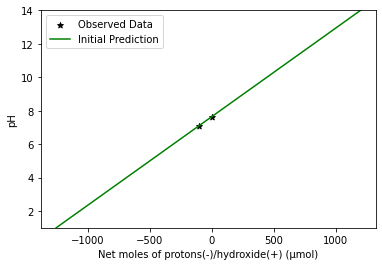

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -338 umol.
Dispensing 137 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,7.65,0
1,-72,-102.100133,7.11,41
2,-209,-273.956170,6.44,52


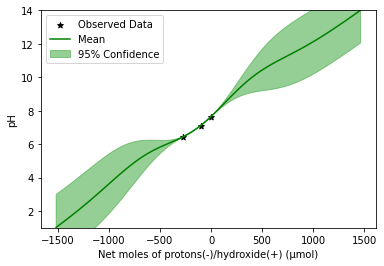

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -492 umol.
Dispensing 205 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,7.650,0
1,-72,-102.100133,7.110,41
2,-209,-273.956170,6.440,52
3,-414,-495.994687,5.885,46


SAMPLE WITHIN TARGET pH RANGE! :)
Titration complete


In [34]:
run_pHAdjustment(jar='A1_1', pH_dev=0.02, dpHdt_dev=0.0025, titrant_A="Citric acid", titrant_B="Sodium hydroxide",
                 A_conc=0.5, B_conc=0.5, V_sample=10, pH_target=5.8, save_name='S533_26-05-2023_pH5.8', save_data=True)

# 3. Platform Operation


### Titrating a batch of samples

In [36]:
def batch_titration(samples, samples_loc, pH_target, pH_dev, dpHdt_dev):
    '''
    samples = list of samples to be titrated, samples is a list of sample names, e.g., ['S1', 'S2', ... , 'S6']
    samples_loc = dictionary of jar locations to the corresponding sample names provided in sample list
    '''
    for i in samples:
        jar = samples_loc[i]
        save_name = i + '_' + datetime.today().strftime('%d-%m-%Y') + '_pH' + str(pH_target)
        run_pHAdjustment(jar, pH_dev, dpHdt_dev, titrant_A="Citric acid", titrant_B="Sodium hydroxide",
                 A_conc=0.5, B_conc=0.5, V_sample=10, pH_target=pH_target, save_name=save_name, save_data=True)
        channel_stirrer(jar)
        wash()
    platform.home()

In [37]:
samples = ['S534','S532','S523','S524'] # names of samples to be titrated

samples_loc = {
    'S534': 'A1_1',
    'S532': 'A2_1',
    'S523': 'A3_1',
    'S524': 'B3_1'
}

Dispensing 62 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,6.80,0
1,-62,-77.966746,6.45,36


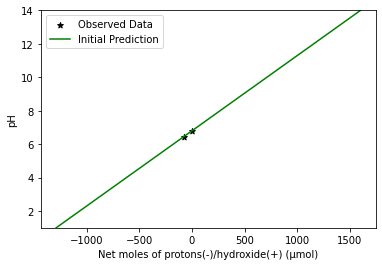

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -209 umol.
Dispensing 70 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,6.800,0
1,-62,-77.966746,6.450,36
2,-132,-159.694872,6.165,31


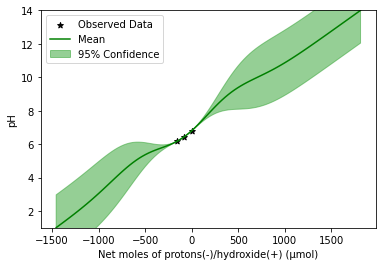

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -299 umol.
Dispensing 131 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,6.800,0
1,-62,-77.966746,6.450,36
2,-132,-159.694872,6.165,31
3,-263,-298.421380,5.800,31


SAMPLE WITHIN TARGET pH RANGE! :)
Titration complete
Washing complete
Dispensing 93 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41


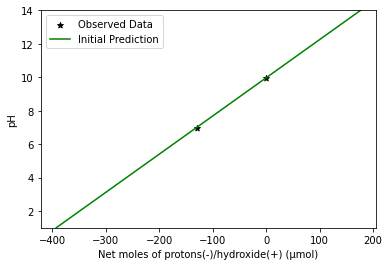

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -179 umol.
Dispensing 31 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41
2,-124,-171.418750,6.720,36


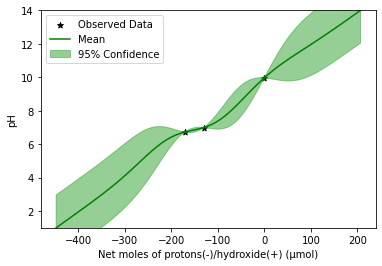

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -235 umol.
Dispensing 60 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41
2,-124,-171.418750,6.720,36
3,-184,-245.650692,6.385,36


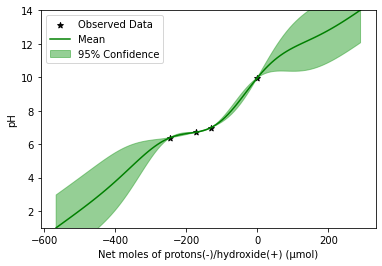

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -289 umol.
Dispensing 40 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41
2,-124,-171.418750,6.720,36
3,-184,-245.650692,6.385,36
4,-224,-292.982578,6.215,31


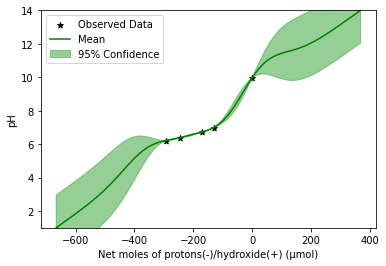

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -352 umol.
Dispensing 55 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41
2,-124,-171.418750,6.720,36
3,-184,-245.650692,6.385,36
4,-224,-292.982578,6.215,31
5,-279,-354.824125,6.025,31


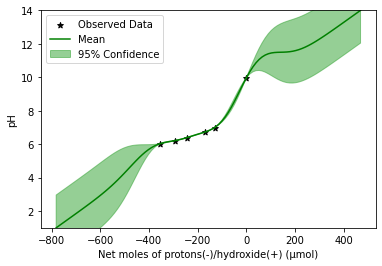

Predicted moles of H+/OH- ions to reach target (pH = 5.8): -389 umol.
Dispensing 32 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,9.965,0
1,-93,-130.013719,6.995,41
2,-124,-171.418750,6.720,36
3,-184,-245.650692,6.385,36
4,-224,-292.982578,6.215,31
5,-279,-354.824125,6.025,31
6,-311,-389.761493,5.915,305


SAMPLE WITHIN TARGET pH RANGE! :)
Titration complete
Washing complete
Dispensing 74 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,6.100,0
1,-74,-80.150489,5.885,31


SAMPLE WITHIN TARGET pH RANGE! :)
Titration complete
Washing complete
Dispensing 96 uL acid is complete


,Net volume of acid(-)/base(+) (μL),Net moles of protons(-)/hydroxide(+) (μmol),pH of Sample,Mixing time (s)
0,0,0.000000,8.800,0
1,-96,-106.219894,5.965,113


SAMPLE WITHIN TARGET pH RANGE! :)
Titration complete
Washing complete
0, 0, 90


In [38]:
batch_titration(samples, samples_loc, pH_target=5.8, pH_dev=0.02, dpHdt_dev=0.0025)